# Lab 5

### Authors:
- Riley Galante
- Jeffrey Taylor
- Austin Hayden
- Eric Bernard

In [10]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import metrics as mt 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Video_games_esrb_rating.csv')

# map the esrb string values to integers for our target
rating = []

for i in df['esrb_rating']:
    if(i == 'E'):
        rating.append(0)
    elif(i == 'ET'):
        rating.append(1)
    elif(i == 'T'):
        rating.append(2)
    else:
        rating.append(3)
        
del df['title'] #get rid of unnecessary data
del df['console']
del df['esrb_rating'] #get rid of original column since its been mapped now

print(df.dtypes)
print("\n{:+^60s}\n".format(""))
print(df.info())

alcohol_reference           int64
animated_blood              int64
blood                       int64
blood_and_gore              int64
cartoon_violence            int64
crude_humor                 int64
drug_reference              int64
fantasy_violence            int64
intense_violence            int64
language                    int64
lyrics                      int64
mature_humor                int64
mild_blood                  int64
mild_cartoon_violence       int64
mild_fantasy_violence       int64
mild_language               int64
mild_lyrics                 int64
mild_suggestive_themes      int64
mild_violence               int64
no_descriptors              int64
nudity                      int64
partial_nudity              int64
sexual_content              int64
sexual_themes               int64
simulated_gambling          int64
strong_janguage             int64
strong_sexual_content       int64
suggestive_themes           int64
use_of_alcohol              int64
use_of_drugs_a

### Final Dataset Description
For this dataset, the columns are descriptors that go into the esrb rating for a video game. All those colums are binary data, where 1 represents a video game that has that particular attribute and 0 means it does not. Because the esrb rating was in string format, we encoded it. This is seen in the rating array created, that will be changed into a numpy array and transposed into a column so that it can be interpreted as the target data by the classifier. The values encoded were 0, 1, 2, and 3, representing E for everyone, E 10+, T for Teen, and M for Mature respectively. Additionally, we removed unnecessary information from the dataset that would not help our prediction, like the titles and console of the video games.

In [2]:
from sklearn.model_selection import ShuffleSplit

y = np.array(rating).T

#remaining columns in dataset are used for X
X = df.to_numpy()

#set up shuffle split using example
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations, test_size = 0.2)
for train_index, test_index in cv_object.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_tensor, outputs=predictions)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [3]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)
from sklearn import metrics as mt
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

Epoch 1/10
31/31 [==============================] - 0s 937us/step - loss: 2.0515 - accuracy: 0.2460
Epoch 2/10
31/31 [==============================] - 0s 935us/step - loss: 1.8169 - accuracy: 0.2157
Epoch 3/10
31/31 [==============================] - 0s 935us/step - loss: 1.6655 - accuracy: 0.2157
Epoch 4/10
31/31 [==============================] - 0s 737us/step - loss: 1.5707 - accuracy: 0.2157
Epoch 5/10
31/31 [==============================] - 0s 1ms/step - loss: 1.5152 - accuracy: 0.2157
Epoch 6/10
31/31 [==============================] - 0s 903us/step - loss: 1.4804 - accuracy: 0.2157
Epoch 7/10
31/31 [==============================] - 0s 1000us/step - loss: 1.4562 - accuracy: 0.2157
Epoch 8/10
31/31 [==============================] - 0s 775us/step - loss: 1.4390 - accuracy: 0.2157
Epoch 9/10
31/31 [==============================] - 0s 838us/step - loss: 1.4263 - accuracy: 0.2157
Epoch 10/10
31/31 [==============================] - 0s 871us/step - loss: 1.4164 - accuracy: 0.2157


C:\Users\infin\.conda\envs\mlenv2020\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
embed_branches = []
all_branch_outputs = []

input_branch = Input(shape =( X_train.shape[1],),
                    dtype='int64',
                    name='categorical')


for y in range(X_train.shape[1]):
    N = max(X_train[y].max(),X_test[y].max())+1
    x = tf.gather(input_branch, y, axis = 1)
    
    x = Embedding(input_dim=N,
                 output_dim=int(np.sqrt(N)),
                 input_length = 1)(x)
    
    all_branch_outputs.append(x)
    
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units = 1,
                    activation='sigmoid',
                    name='combined')(final_branch)
model = Model(inputs=input_branch, outputs=final_branch)

model.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])
model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical (InputLayer)        [(None, 31)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_GatherV2 (TensorFlo [(None,)]            0           categorical[0][0]                
__________________________________________________________________________________________________
tf_op_layer_GatherV2_1 (TensorF [(None,)]            0           categorical[0][0]                
__________________________________________________________________________________________________
tf_op_layer_GatherV2_2 (TensorF [(None,)]            0           categorical[0][0]                
_______________________________________________________________________________________

In [5]:
%%time

model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=1)

from sklearn import metrics as mt
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

Epoch 1/1000
31/31 [==============================] - 0s 968us/step - loss: 2.0598 - accuracy: 0.2170
Epoch 2/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.8938 - accuracy: 0.2157
Epoch 3/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.7688 - accuracy: 0.2157
Epoch 4/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.6781 - accuracy: 0.2157
Epoch 5/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.6134 - accuracy: 0.2157
Epoch 6/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.5664 - accuracy: 0.2157
Epoch 7/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.5317 - accuracy: 0.2157
Epoch 8/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.5051 - accuracy: 0.2157
Epoch 9/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.4847 - accuracy: 0.2157
Epoch 10/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.4688 - accuracy: 0.21

Epoch 82/1000
31/31 [==============================] - 0s 935us/step - loss: 1.3700 - accuracy: 0.2157
Epoch 83/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3699 - accuracy: 0.2157
Epoch 84/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3698 - accuracy: 0.2157
Epoch 85/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3697 - accuracy: 0.2157
Epoch 86/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3696 - accuracy: 0.2157
Epoch 87/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3695 - accuracy: 0.2157
Epoch 88/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3694 - accuracy: 0.2157
Epoch 89/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3694 - accuracy: 0.2157
Epoch 90/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3693 - accuracy: 0.2157
Epoch 91/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3692 - accur

31/31 [==============================] - 0s 1ms/step - loss: 1.3665 - accuracy: 0.2157
Epoch 163/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3665 - accuracy: 0.2157
Epoch 164/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3665 - accuracy: 0.2157
Epoch 165/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3665 - accuracy: 0.2157
Epoch 166/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3665 - accuracy: 0.2157
Epoch 167/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3665 - accuracy: 0.2157
Epoch 168/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3664 - accuracy: 0.2157
Epoch 169/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3664 - accuracy: 0.2157
Epoch 170/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3664 - accuracy: 0.2157
Epoch 171/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3664 - accuracy: 0.

31/31 [==============================] - 0s 2ms/step - loss: 1.3656 - accuracy: 0.2157
Epoch 243/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3656 - accuracy: 0.2157
Epoch 244/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3656 - accuracy: 0.2157
Epoch 245/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3656 - accuracy: 0.2157
Epoch 246/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3656 - accuracy: 0.2157
Epoch 247/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3655 - accuracy: 0.2157
Epoch 248/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3655 - accuracy: 0.2157
Epoch 249/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3655 - accuracy: 0.2157
Epoch 250/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3655 - accuracy: 0.2157
Epoch 251/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3655 - accuracy: 0.

31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 323/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 324/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 325/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 326/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 327/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 328/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 329/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 330/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.2157
Epoch 331/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.

31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 403/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 404/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 405/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 406/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 407/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 408/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 409/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 410/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3649 - accuracy: 0.2157
Epoch 411/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3649 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 483/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 484/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 485/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 486/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 487/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 488/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 489/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 490/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3647 - accuracy: 0.2157
Epoch 491/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3647 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 563/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 564/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 565/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 566/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 567/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 568/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 569/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 570/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 571/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 643/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 644/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 645/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 646/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 647/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 648/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 649/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157
Epoch 650/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3646 - accuracy: 0.2157: 0s - loss: 1.3604 - accuracy: 0.21
Epoch 651/1000
31/31 [==============================] - 0s 2m

31/31 [==============================] - 0s 1ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 723/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 724/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 725/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 726/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 727/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 728/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 729/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 730/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 731/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3645 - accuracy: 0.

31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 803/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 804/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 805/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 806/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 807/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 808/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 809/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 810/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.2157
Epoch 811/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3645 - accuracy: 0.

31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 883/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 884/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 885/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 886/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 887/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 888/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 889/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 890/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 891/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 963/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 964/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 965/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 966/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 967/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 968/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 969/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 970/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.2157
Epoch 971/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3644 - accuracy: 0.

In [11]:
cross_columns = [['alcohol_reference','drug_reference'],
                 ['animated_blood', 'blood', 'blood_and_gore'],
                 ['cartoon_violence','fantasy_violence','intense_violence'],
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = X_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    X_train[cross_col_name] = enc.transform(X_crossed_train)
    X_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

C:\Users\infin\.conda\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Epoch 1/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 2/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 3/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 4/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 5/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 6/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 7/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 8/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 9/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 10/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 83/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 84/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 85/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 86/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 87/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 88/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 89/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 90/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 91/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoc

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 163/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 164/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 165/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 166/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 167/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 168/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 169/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 170/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 171/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 243/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 244/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 245/1000
31/31 [==============================] - 0s 1000us/step - loss: 1.3642 - accuracy: 0.2157
Epoch 246/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 247/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 248/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 249/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 250/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 251/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy:

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 323/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 324/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 325/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 326/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 327/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 328/1000
31/31 [==============================] - 0s 839us/step - loss: 1.3642 - accuracy: 0.2157
Epoch 329/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 330/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 331/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 403/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 404/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 405/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 406/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 407/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 408/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 409/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 410/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 411/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 483/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 484/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 485/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 486/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 487/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 488/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 489/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 490/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 491/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 563/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 564/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 565/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 566/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 567/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 568/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 569/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 570/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 571/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 643/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 644/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 645/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 646/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 647/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 648/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 649/1000
31/31 [==============================] - 0s 968us/step - loss: 1.3642 - accuracy: 0.2157
Epoch 650/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 651/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 723/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 724/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 725/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 726/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 727/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 728/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 729/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 730/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 731/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 803/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 804/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 805/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 806/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 807/1000
31/31 [==============================] - ETA: 0s - loss: 1.3000 - accuracy: 0.24 - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 808/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 809/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 810/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 811/1000
31/31 [==============================] -

Epoch 882/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 883/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 884/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 885/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 886/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 887/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 888/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 889/1000
31/31 [==============================] - 0s 3ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 890/1000
31/31 [==============================] - 0s 3ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 891/1000
31/31 [==============================] - 0s 2ms/step - loss: 1.3642

31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 962/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 963/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 964/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 965/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 966/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 967/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 968/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 969/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.2157
Epoch 970/1000
31/31 [==============================] - 0s 1ms/step - loss: 1.3642 - accuracy: 0.

Text(0.5, 0, 'epochs')

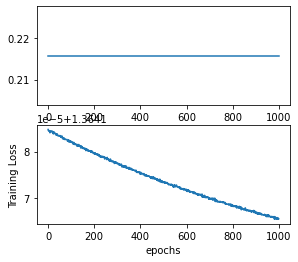

In [17]:
from matplotlib import pyplot as plt

history = model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=1)

from sklearn import metrics as mt
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

#plt.ylabel('Accuracy %')
#plt.title('Training')
#plt.subplot(2,2,2)
#plt.plot(history.history['val_accuracy'])
#plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

#plt.subplot(2,2,4)
#plt.plot(history.history['val_loss'])
#plt.xlabel('epochs')

dict_keys(['loss', 'accuracy'])
